# Project 4 Part II

## by Joseph Naro and Preeti Kumari

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix

## This is just showing the data set more

In [4]:
input_file = 'realTraffic/speed_6005.csv'

In [5]:
df = pd.read_csv('/content/gdrive/My Drive/' + input_file)
df

,timestamp,value
0,2015-08-31 18:22:00,90
1,2015-08-31 18:32:00,80
2,2015-08-31 18:57:00,84
3,2015-08-31 19:07:00,94
4,2015-08-31 19:12:00,90
...,...,...
2495,2015-09-17 16:04:00,81
2496,2015-09-17 16:09:00,89
2497,2015-09-17 16:14:00,87
2498,2015-09-17 16:19:00,82


In [6]:
df.describe()

,value
count,2500.000000
mean,81.906800
std,8.746606
min,20.000000
25%,77.000000
50%,82.000000
75%,88.000000
max,109.000000


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df

,value
timestamp,
2015-08-31 18:22:00,90
2015-08-31 18:32:00,80
2015-08-31 18:57:00,84
2015-08-31 19:07:00,94
2015-08-31 19:12:00,90
...,...
2015-09-17 16:04:00,81
2015-09-17 16:09:00,89
2015-09-17 16:14:00,87


## Here we are getting the indexes of the relevant anomalies from another file

In [8]:
anomalies = json.load(open('/content/gdrive/My Drive/combined_windows.json'))
anomalies

{'artificialNoAnomaly/art_daily_no_noise.csv': [],
 'artificialNoAnomaly/art_daily_perfect_square_wave.csv': [],
 'artificialNoAnomaly/art_daily_small_noise.csv': [],
 'artificialNoAnomaly/art_flatline.csv': [],
 'artificialNoAnomaly/art_noisy.csv': [],
 'artificialWithAnomaly/art_daily_flatmiddle.csv': [['2014-04-10 07:15:00.000000',
   '2014-04-11 16:45:00.000000']],
 'artificialWithAnomaly/art_daily_jumpsdown.csv': [['2014-04-10 16:15:00.000000',
   '2014-04-12 01:45:00.000000']],
 'artificialWithAnomaly/art_daily_jumpsup.csv': [['2014-04-10 16:15:00.000000',
   '2014-04-12 01:45:00.000000']],
 'artificialWithAnomaly/art_daily_nojump.csv': [['2014-04-10 16:15:00.000000',
   '2014-04-12 01:45:00.000000']],
 'artificialWithAnomaly/art_increase_spike_density.csv': [['2014-04-07 06:25:00.000000',
   '2014-04-08 15:55:00.000000']],
 'artificialWithAnomaly/art_load_balancer_spikes.csv': [['2014-04-10 11:50:00.000000',
   '2014-04-11 21:20:00.000000']],
 'realAWSCloudwatch/ec2_cpu_utilizat

In [9]:
relevant_anomalies = anomalies[input_file]
for index in range(len(relevant_anomalies)):
    relevant_anomalies[index] = pd.to_datetime(relevant_anomalies[index])
    
relevant_anomalies

[DatetimeIndex(['2015-09-16 18:40:00', '2015-09-17 16:24:00'], dtype='datetime64[ns]', freq=None)]

### Below we have all of the data being used plotted nicely. THe plot shows traffic speeds. The lack of data itself is a type of anomaly, but it is not what we are looking for this time. I checked the dates given and it looks like the long gap without any data was a weekend and a Monday. It is reasonable to infer that the data collector had the weekend off.

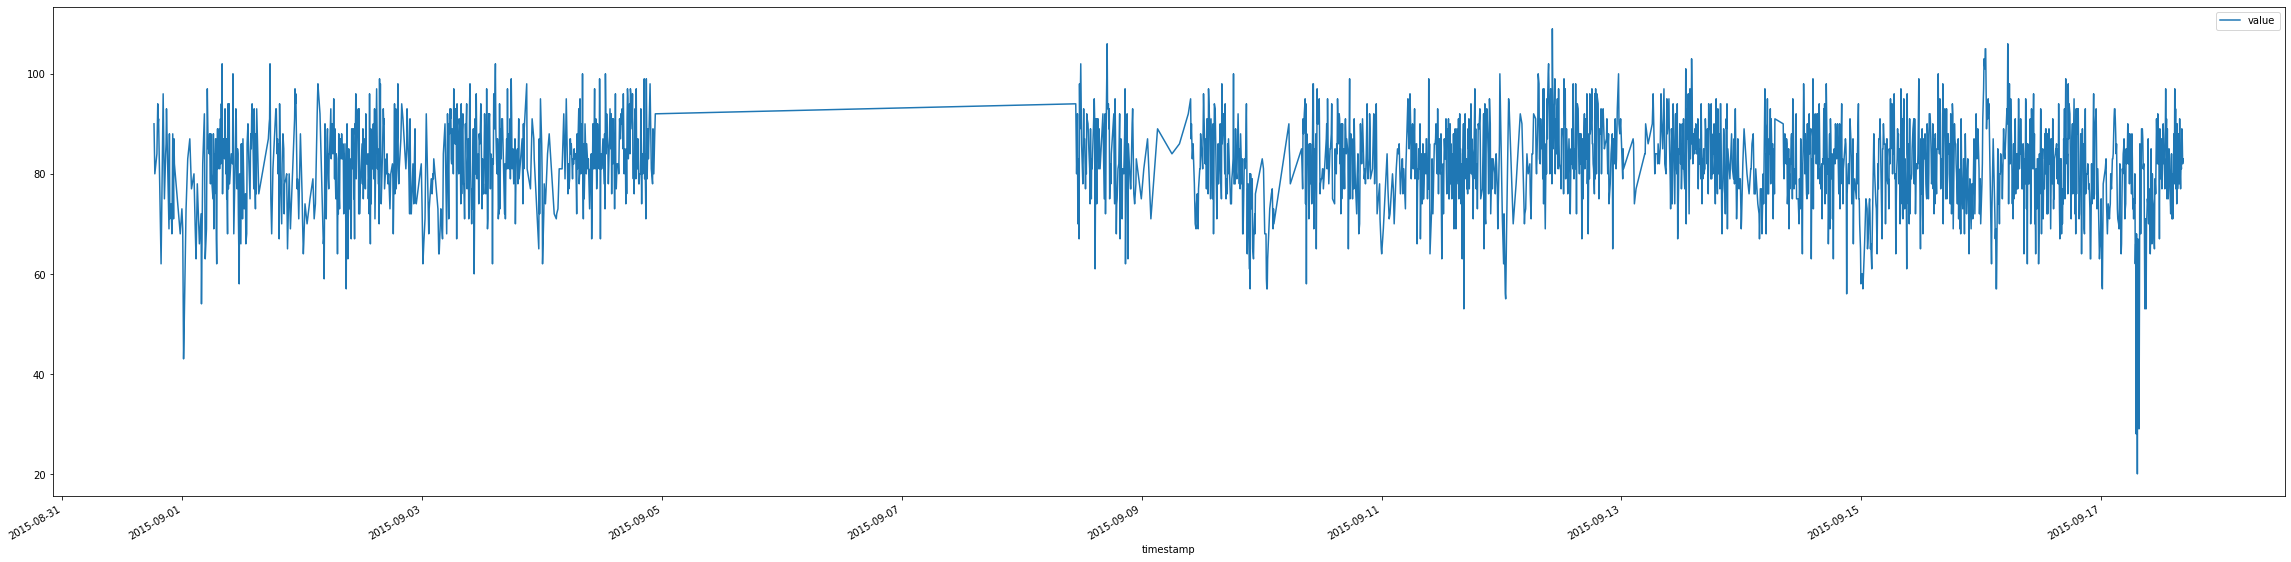

In [10]:
df.plot(figsize=(40,10))

In [11]:
anomaly_intervals = pd.DataFrame()

for interval in relevant_anomalies:
    anomaly_intervals = anomaly_intervals.append(df.loc[interval[0]:interval[1]])

anomaly_intervals

,value
timestamp,
2015-09-16 18:40:00,84
2015-09-16 18:45:00,72
2015-09-16 18:50:00,83
2015-09-16 18:55:00,68
2015-09-16 19:00:00,93
...,...
2015-09-17 16:04:00,81
2015-09-17 16:09:00,89
2015-09-17 16:14:00,87


### This plot show has the anomaly colored in orage to highlight it. There is an obvious downward spike, likely the result of some sort of traffic jam.

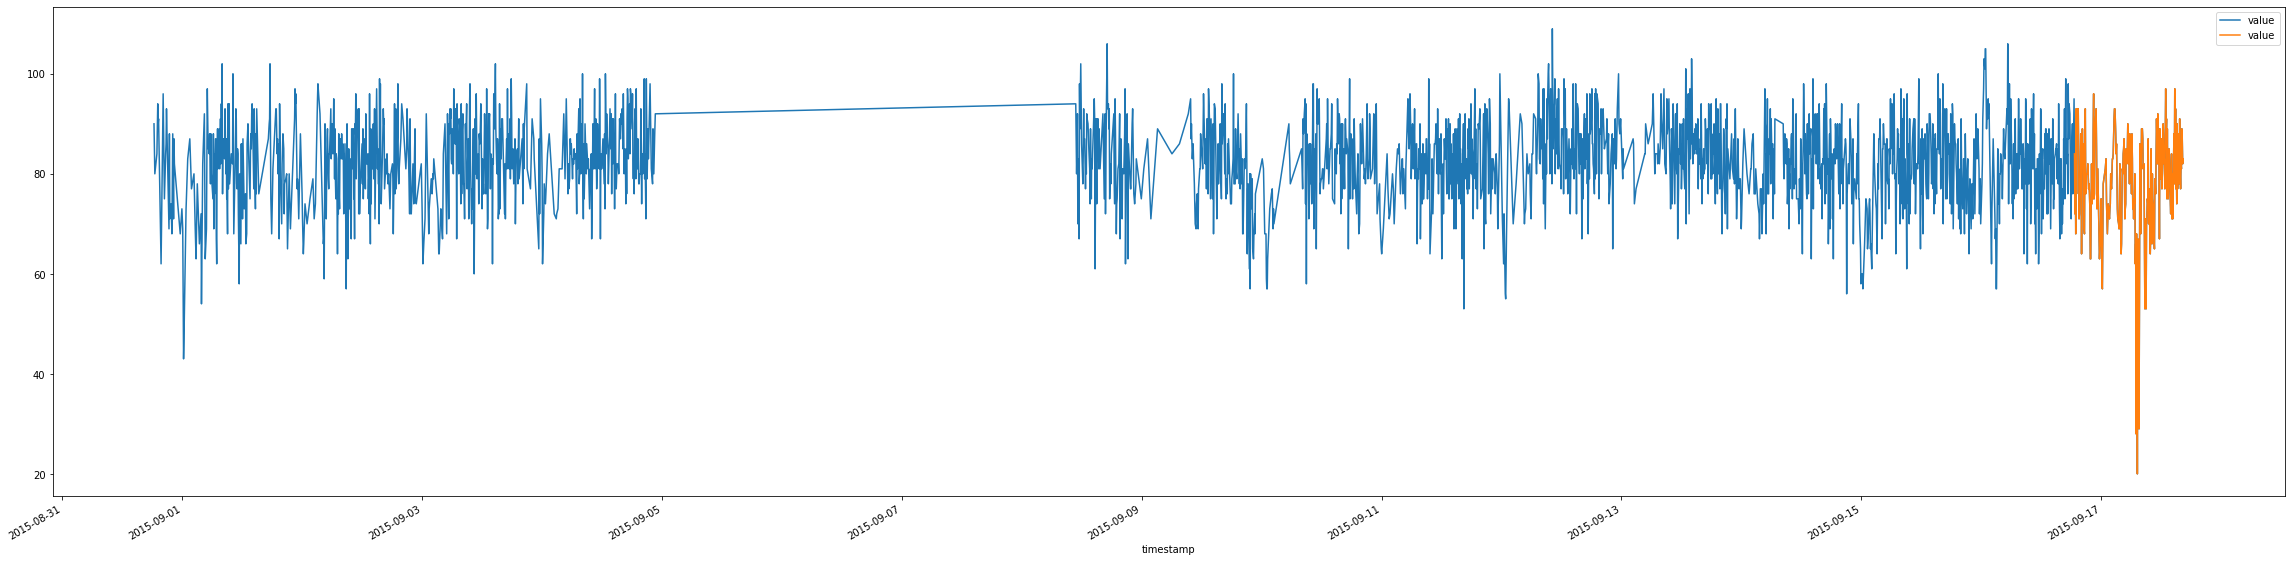

In [12]:
ax = df.plot(figsize=(40,10))
anomaly_intervals.plot(figsize=(40,10), ax=ax)

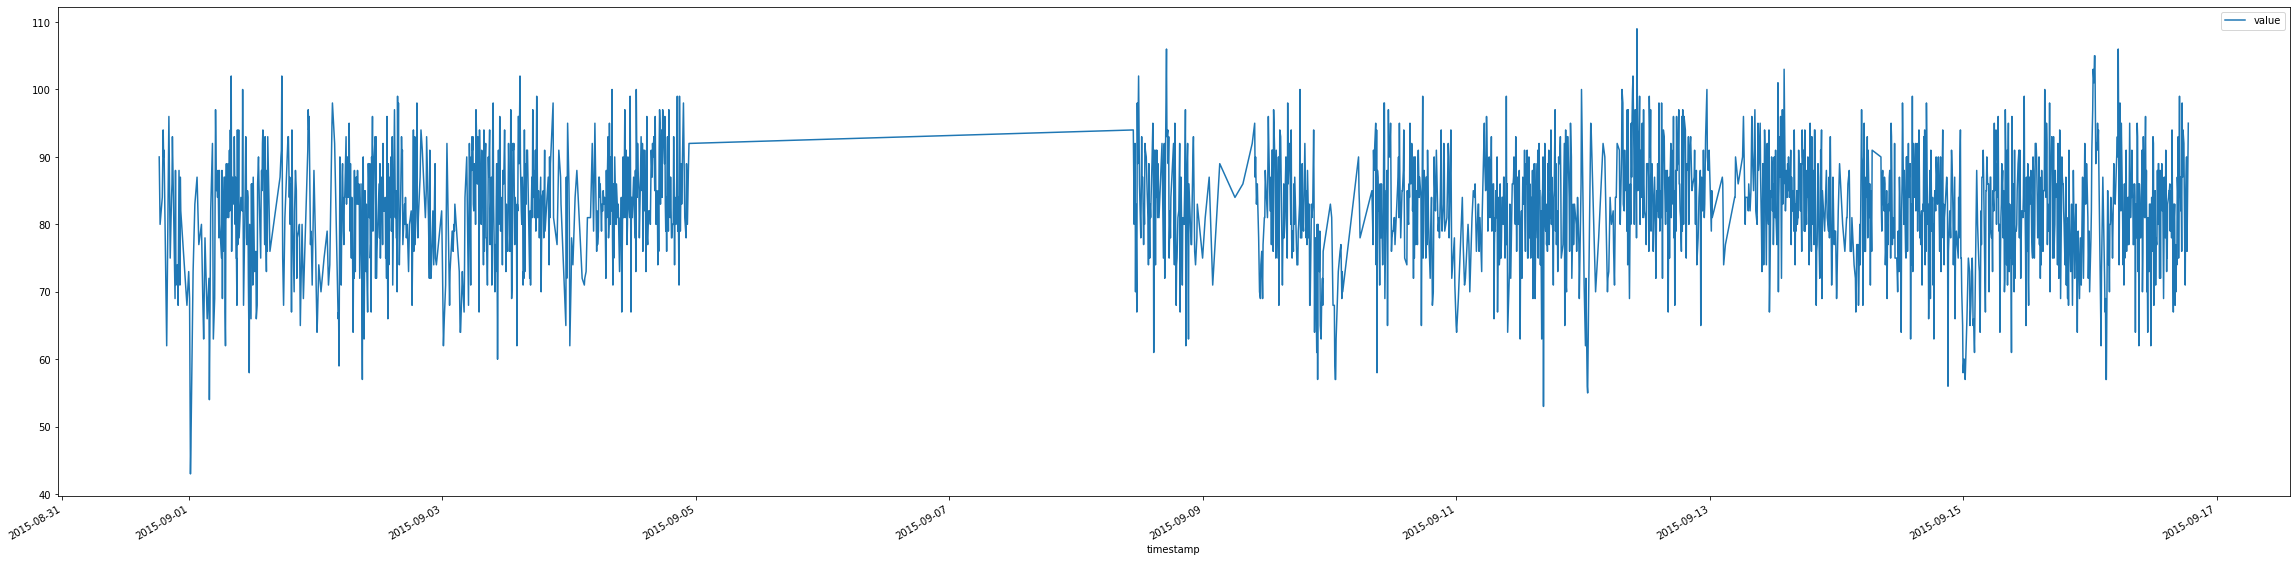

In [13]:
x = ((df.reset_index()).append(anomaly_intervals.reset_index()))
x.drop_duplicates(keep=False, inplace=True)
x.set_index('timestamp', inplace=True)
x.plot(figsize=(40,10))

In [14]:
input_len = 128

In [15]:
x = x.to_numpy()
x_data = []

for i in range(len(x)-input_len+1):
    x_data.append(x[i:i+input_len])
    
x_data = np.array(x_data).squeeze()
np.random.shuffle(x_data)

x_train = x_data[:int(len(x_data)*.8)]
x_test = x_data[int(len(x_data)*.8):]

In [16]:
dense_scores = []

# Part II: 1, 2, & 3

### The different parts of this projects are intertwined, so I cannot easily separate it into parts.

### For part 2: 2, I am going to be tuning a dense autoencoder.

In [17]:
stopper = EarlyStopping(monitor='val_loss', min_delta=1, patience=7, restore_best_weights=True)

In [18]:
dense_model_1 = Sequential()
dense_model_1.add(layers.Dense(64, activation='relu', input_shape=(input_len,)))
dense_model_1.add(layers.Dense(32, activation='relu'))
dense_model_1.add(layers.Dense(8, activation='relu'))
dense_model_1.add(layers.Dense(32, activation='relu'))
dense_model_1.add(layers.Dense(64, activation='relu'))
dense_model_1.add(layers.Dense(input_len, activation='relu'))
dense_model_1.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
Total params: 21,320
Trainable params: 21,320
Non-trainable params: 0
____________________________________________________

In [19]:
dense_model_1_history = dense_model_1.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_1.save_weights('/content/gdrive/My Drive/dense_model_1.h5')

Epoch 1/40
22/22 [==============================] - 0s 9ms/step - loss: 3954.2571 - mse: 3954.2571 - val_loss: 2753.5942 - val_mse: 2753.5942
Epoch 2/40
22/22 [==============================] - 0s 3ms/step - loss: 2440.5876 - mse: 2440.5876 - val_loss: 2235.0601 - val_mse: 2235.0601
Epoch 3/40
22/22 [==============================] - 0s 3ms/step - loss: 2209.5840 - mse: 2209.5840 - val_loss: 2193.9231 - val_mse: 2193.9231
Epoch 4/40
22/22 [==============================] - 0s 3ms/step - loss: 2193.8271 - mse: 2193.8271 - val_loss: 2189.7693 - val_mse: 2189.7693
Epoch 5/40
22/22 [==============================] - 0s 3ms/step - loss: 2192.1606 - mse: 2192.1606 - val_loss: 2189.3630 - val_mse: 2189.3630
Epoch 6/40
22/22 [==============================] - 0s 3ms/step - loss: 2192.0283 - mse: 2192.0283 - val_loss: 2189.2795 - val_mse: 2189.2795
Epoch 7/40
22/22 [==============================] - 0s 4ms/step - loss: 2191.9673 - mse: 2191.9673 - val_loss: 2189.2913 - val_mse: 2189.2913
Epoch 

In [20]:
dense_model_1_score = dense_model_1.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_1_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 2194.1211 - mse: 2194.1211


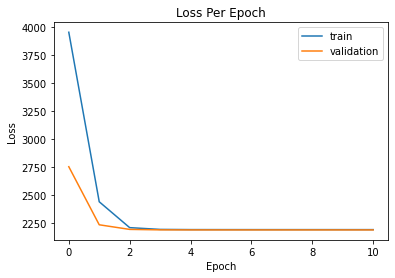

In [21]:
plt.plot(dense_model_1_history.history['loss'])
plt.plot(dense_model_1_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## It looks like the first model was quick to reach a minimum loss value, but the loss is pretty bad. An MSE of 2250 means that on average, the predictions were off by about 47 units of speed. That's not helpful.

In [22]:
dense_model_2 = Sequential()
dense_model_2.add(layers.Dense(64, activation='relu', input_shape=(input_len,)))
dense_model_2.add(layers.Dense(8, activation='relu'))
dense_model_2.add(layers.Dense(64, activation='relu'))
dense_model_2.add(layers.Dense(input_len, activation='relu'))
dense_model_2.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
Total params: 17,672
Trainable params: 17,672
Non-trainable params: 0
_________________________________________________________________


In [23]:
dense_model_2_history = dense_model_2.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_2.save_weights('/content/gdrive/My Drive/dense_model_2.h5')

Epoch 1/40
22/22 [==============================] - 0s 7ms/step - loss: 3747.0811 - mse: 3747.0811 - val_loss: 3022.1660 - val_mse: 3022.1660
Epoch 2/40
22/22 [==============================] - 0s 3ms/step - loss: 2970.5881 - mse: 2970.5881 - val_loss: 2950.8689 - val_mse: 2950.8689
Epoch 3/40
22/22 [==============================] - 0s 3ms/step - loss: 2938.1604 - mse: 2938.1604 - val_loss: 2942.5947 - val_mse: 2942.5947
Epoch 4/40
22/22 [==============================] - 0s 3ms/step - loss: 2934.6743 - mse: 2934.6743 - val_loss: 2941.6509 - val_mse: 2941.6509
Epoch 5/40
22/22 [==============================] - 0s 3ms/step - loss: 2934.2859 - mse: 2934.2859 - val_loss: 2941.4651 - val_mse: 2941.4651
Epoch 6/40
22/22 [==============================] - 0s 3ms/step - loss: 2934.2087 - mse: 2934.2087 - val_loss: 2941.4355 - val_mse: 2941.4355
Epoch 7/40
22/22 [==============================] - 0s 3ms/step - loss: 2934.2180 - mse: 2934.2180 - val_loss: 2941.4539 - val_mse: 2941.4539
Epoch 

In [24]:
dense_model_2_score = dense_model_2.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_2_score[0])

14/14 [==============================] - 0s 1ms/step - loss: 2935.7524 - mse: 2935.7524


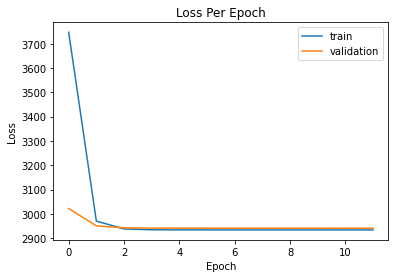

In [25]:
plt.plot(dense_model_2_history.history['loss'])
plt.plot(dense_model_2_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## Unsurprisingly, reducing the amount of layers in the autoencoder did not make it more accurate. It is interesting to note that it did reach its best loss in about the same time though.

Text(0, 0.5, 'Loss (MSE)')

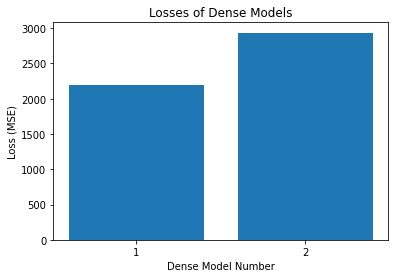

In [26]:
plt.bar(range(1,len(dense_scores)+1), dense_scores)
plt.xticks(range(1,len(dense_scores)+1))
plt.title('Losses of Dense Models')
plt.xlabel('Dense Model Number')
plt.ylabel('Loss (MSE)')

In [27]:
dense_model_3 = Sequential()
dense_model_3.add(layers.Dense(64, activation='relu', input_shape=(input_len,)))
dense_model_3.add(layers.Dense(32, activation='relu'))
dense_model_3.add(layers.Dense(16, activation='relu'))
dense_model_3.add(layers.Dense(8, activation='relu'))
dense_model_3.add(layers.Dense(16, activation='relu'))
dense_model_3.add(layers.Dense(32, activation='relu'))
dense_model_3.add(layers.Dense(64, activation='relu'))
dense_model_3.add(layers.Dense(input_len, activation='relu'))
dense_model_3.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_14 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_15 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

In [28]:
dense_model_3_history = dense_model_3.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_3.save_weights('/content/gdrive/My Drive/dense_model_3.h5')

Epoch 1/40
22/22 [==============================] - 0s 8ms/step - loss: 4666.5713 - mse: 4666.5713 - val_loss: 3136.2532 - val_mse: 3136.2532
Epoch 2/40
22/22 [==============================] - 0s 3ms/step - loss: 2818.6248 - mse: 2818.6248 - val_loss: 2596.7527 - val_mse: 2596.7527
Epoch 3/40
22/22 [==============================] - 0s 4ms/step - loss: 2538.5940 - mse: 2538.5940 - val_loss: 2519.1887 - val_mse: 2519.1887
Epoch 4/40
22/22 [==============================] - 0s 4ms/step - loss: 2510.5176 - mse: 2510.5176 - val_loss: 2514.0103 - val_mse: 2514.0103
Epoch 5/40
22/22 [==============================] - 0s 3ms/step - loss: 2508.2683 - mse: 2508.2683 - val_loss: 2513.4883 - val_mse: 2513.4883
Epoch 6/40
22/22 [==============================] - 0s 4ms/step - loss: 2508.0354 - mse: 2508.0354 - val_loss: 2513.4365 - val_mse: 2513.4365
Epoch 7/40
22/22 [==============================] - 0s 4ms/step - loss: 2507.9514 - mse: 2507.9514 - val_loss: 2513.4473 - val_mse: 2513.4473
Epoch 

In [29]:
dense_model_3_score = dense_model_3.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_3_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 2512.3083 - mse: 2512.3083


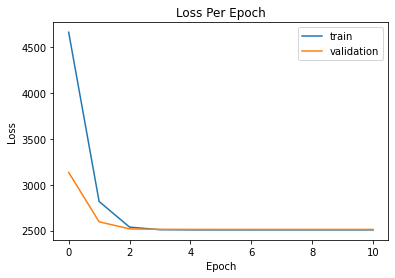

In [30]:
plt.plot(dense_model_3_history.history['loss'])
plt.plot(dense_model_3_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## Adding another pair of layers did not help either. Now would be a good time for a new approach

Text(0, 0.5, 'Loss (MSE)')

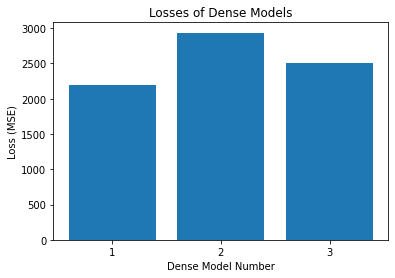

In [31]:
plt.bar(range(1,len(dense_scores)+1), dense_scores)
plt.xticks(range(1,len(dense_scores)+1))
plt.title('Losses of Dense Models')
plt.xlabel('Dense Model Number')
plt.ylabel('Loss (MSE)')

In [32]:
dense_model_4 = Sequential()
dense_model_4.add(layers.Dense(64, activation='relu', input_shape=(input_len,)))
dense_model_4.add(layers.Dense(32, activation='relu'))
dense_model_4.add(layers.Dense(8, activation='relu'))
dense_model_4.add(layers.Dense(4, activation='relu'))
dense_model_4.add(layers.Dense(8, activation='relu'))
dense_model_4.add(layers.Dense(32, activation='relu'))
dense_model_4.add(layers.Dense(64, activation='relu'))
dense_model_4.add(layers.Dense(input_len, activation='relu'))
dense_model_4.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_23 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_24 (Dense)             (None, 64)               

In [33]:
dense_model_4_history = dense_model_4.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_4.save_weights('/content/gdrive/My Drive/dense_model_4.h5')

Epoch 1/40
22/22 [==============================] - 0s 8ms/step - loss: 4536.7222 - mse: 4536.7222 - val_loss: 3215.8831 - val_mse: 3215.8831
Epoch 2/40
22/22 [==============================] - 0s 4ms/step - loss: 2989.4160 - mse: 2989.4160 - val_loss: 2854.3154 - val_mse: 2854.3154
Epoch 3/40
22/22 [==============================] - 0s 4ms/step - loss: 2805.1147 - mse: 2805.1147 - val_loss: 2779.8628 - val_mse: 2779.8628
Epoch 4/40
22/22 [==============================] - 0s 4ms/step - loss: 2778.5271 - mse: 2778.5271 - val_loss: 2776.3032 - val_mse: 2776.3032
Epoch 5/40
22/22 [==============================] - 0s 4ms/step - loss: 2776.6531 - mse: 2776.6531 - val_loss: 2775.7122 - val_mse: 2775.7122
Epoch 6/40
22/22 [==============================] - 0s 3ms/step - loss: 2776.4075 - mse: 2776.4075 - val_loss: 2775.6802 - val_mse: 2775.6802
Epoch 7/40
22/22 [==============================] - 0s 4ms/step - loss: 2776.4229 - mse: 2776.4229 - val_loss: 2775.6758 - val_mse: 2775.6758
Epoch 

In [34]:
dense_model_4_score = dense_model_4.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_4_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 2775.8130 - mse: 2775.8130


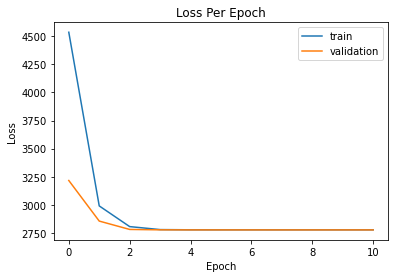

In [35]:
plt.plot(dense_model_4_history.history['loss'])
plt.plot(dense_model_4_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## Narrowing the center of the autoencoder worked a bit, but it still wasn't as good as the first attempt.

Text(0, 0.5, 'Loss (MSE)')

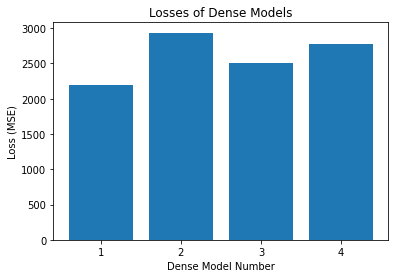

In [36]:
plt.bar(range(1,len(dense_scores)+1), dense_scores)
plt.xticks(range(1,len(dense_scores)+1))
plt.title('Losses of Dense Models')
plt.xlabel('Dense Model Number')
plt.ylabel('Loss (MSE)')

In [37]:
dense_model_5 = Sequential()
dense_model_5.add(layers.Dense(64, activation='relu', input_shape=(input_len,)))
dense_model_5.add(layers.Dense(16, activation='relu'))
dense_model_5.add(layers.Dense(8, activation='relu'))
dense_model_5.add(layers.Dense(16, activation='relu'))
dense_model_5.add(layers.Dense(64, activation='relu'))
dense_model_5.add(layers.Dense(input_len, activation='relu'))
dense_model_5.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_29 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_30 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_31 (Dense)             (None, 128)               8320      
Total params: 18,984
Trainable params: 18,984
Non-trainable params: 0
__________________________________________________

In [38]:
dense_model_5_history = dense_model_5.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_5.save_weights('/content/gdrive/My Drive/dense_model_5.h5')

Epoch 1/40
22/22 [==============================] - 0s 9ms/step - loss: 4307.7280 - mse: 4307.7280 - val_loss: 3273.5171 - val_mse: 3273.5171
Epoch 2/40
22/22 [==============================] - 0s 3ms/step - loss: 3197.6082 - mse: 3197.6082 - val_loss: 3155.7876 - val_mse: 3155.7876
Epoch 3/40
22/22 [==============================] - 0s 3ms/step - loss: 3101.4468 - mse: 3101.4468 - val_loss: 3055.0273 - val_mse: 3055.0273
Epoch 4/40
22/22 [==============================] - 0s 3ms/step - loss: 3044.4163 - mse: 3044.4163 - val_loss: 3048.2751 - val_mse: 3048.2751
Epoch 5/40
22/22 [==============================] - 0s 3ms/step - loss: 3041.4519 - mse: 3041.4519 - val_loss: 3046.7361 - val_mse: 3046.7361
Epoch 6/40
22/22 [==============================] - 0s 3ms/step - loss: 3040.9841 - mse: 3040.9841 - val_loss: 3046.6094 - val_mse: 3046.6094
Epoch 7/40
22/22 [==============================] - 0s 3ms/step - loss: 3040.9336 - mse: 3040.9336 - val_loss: 3046.6050 - val_mse: 3046.6050
Epoch 

In [39]:
dense_model_5_score = dense_model_5.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_5_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 3037.8589 - mse: 3037.8589


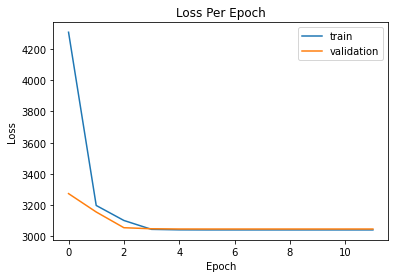

In [40]:
plt.plot(dense_model_5_history.history['loss'])
plt.plot(dense_model_5_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## There does seem to be an advantage to having narrower middle layers, but the loss values are still too bad to use.

Text(0, 0.5, 'Loss (MSE)')

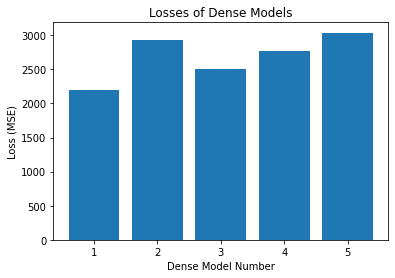

In [41]:
plt.bar(range(1,len(dense_scores)+1), dense_scores)
plt.xticks(range(1,len(dense_scores)+1))
plt.title('Losses of Dense Models')
plt.xlabel('Dense Model Number')
plt.ylabel('Loss (MSE)')

In [42]:
dense_model_6 = Sequential()
dense_model_6.add(layers.Dense(64, activation='relu', input_shape=(input_len,)))
dense_model_6.add(layers.Dense(32, activation='relu'))
dense_model_6.add(layers.Dense(4, activation='relu'))
dense_model_6.add(layers.Dense(32, activation='relu'))
dense_model_6.add(layers.Dense(64, activation='relu'))
dense_model_6.add(layers.Dense(input_len, activation='relu'))
dense_model_6.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 132       
_________________________________________________________________
dense_35 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_36 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_37 (Dense)             (None, 128)               8320      
Total params: 21,060
Trainable params: 21,060
Non-trainable params: 0
__________________________________________________

In [43]:
dense_model_6_history = dense_model_6.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_6.save_weights('/content/gdrive/My Drive/dense_model_6.h5')

Epoch 1/40
22/22 [==============================] - 0s 9ms/step - loss: 4739.4507 - mse: 4739.4507 - val_loss: 3017.5344 - val_mse: 3017.5344
Epoch 2/40
22/22 [==============================] - 0s 4ms/step - loss: 2446.7229 - mse: 2446.7229 - val_loss: 2216.5237 - val_mse: 2216.5237
Epoch 3/40
22/22 [==============================] - 0s 4ms/step - loss: 2164.7305 - mse: 2164.7305 - val_loss: 2142.9060 - val_mse: 2142.9060
Epoch 4/40
22/22 [==============================] - 0s 4ms/step - loss: 2142.4402 - mse: 2142.4402 - val_loss: 2136.1897 - val_mse: 2136.1897
Epoch 5/40
22/22 [==============================] - 0s 4ms/step - loss: 2139.8022 - mse: 2139.8022 - val_loss: 2135.8633 - val_mse: 2135.8633
Epoch 6/40
22/22 [==============================] - 0s 4ms/step - loss: 2139.6345 - mse: 2139.6345 - val_loss: 2135.8540 - val_mse: 2135.8540
Epoch 7/40
22/22 [==============================] - 0s 4ms/step - loss: 2139.6240 - mse: 2139.6240 - val_loss: 2135.7932 - val_mse: 2135.7932
Epoch 

In [44]:
dense_model_6_score = dense_model_6.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_6_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 2137.3247 - mse: 2137.3247


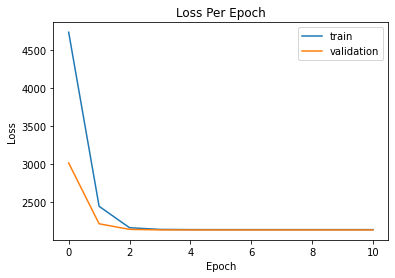

In [45]:
plt.plot(dense_model_6_history.history['loss'])
plt.plot(dense_model_6_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## This model was the same as the first but with 4 neurons in the center instead of 8. The significantly worse reult implies that the trend of the data cannot be broken down into four values.

Text(0, 0.5, 'Loss (MSE)')

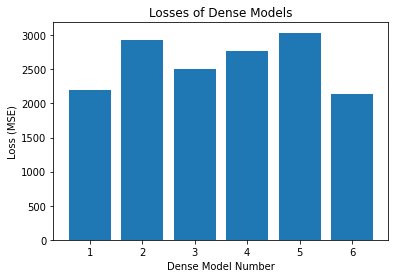

In [46]:
plt.bar(range(1,len(dense_scores)+1), dense_scores)
plt.xticks(range(1,len(dense_scores)+1))
plt.title('Losses of Dense Models')
plt.xlabel('Dense Model Number')
plt.ylabel('Loss (MSE)')

In [47]:
dense_model_7 = Sequential()
dense_model_7.add(layers.Dense(64, activation='elu', input_shape=(input_len,)))
dense_model_7.add(layers.Dense(32, activation='elu'))
dense_model_7.add(layers.Dense(8, activation='elu'))
dense_model_7.add(layers.Dense(32, activation='elu'))
dense_model_7.add(layers.Dense(64, activation='elu'))
dense_model_7.add(layers.Dense(input_len, activation='elu'))
dense_model_7.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_41 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_42 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_43 (Dense)             (None, 128)               8320      
Total params: 21,320
Trainable params: 21,320
Non-trainable params: 0
__________________________________________________

In [48]:
dense_model_7_history = dense_model_7.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_7.save_weights('/content/gdrive/My Drive/dense_model_7.h5')

Epoch 1/40
22/22 [==============================] - 0s 9ms/step - loss: 4085.4634 - mse: 4085.4634 - val_loss: 2464.2947 - val_mse: 2464.2947
Epoch 2/40
22/22 [==============================] - 0s 4ms/step - loss: 2234.3442 - mse: 2234.3442 - val_loss: 2111.9370 - val_mse: 2111.9370
Epoch 3/40
22/22 [==============================] - 0s 4ms/step - loss: 2092.6001 - mse: 2092.6001 - val_loss: 2084.9563 - val_mse: 2084.9563
Epoch 4/40
22/22 [==============================] - 0s 3ms/step - loss: 2081.7048 - mse: 2081.7048 - val_loss: 2081.3333 - val_mse: 2081.3333
Epoch 5/40
22/22 [==============================] - 0s 3ms/step - loss: 2080.3845 - mse: 2080.3845 - val_loss: 2080.9878 - val_mse: 2080.9878
Epoch 6/40
22/22 [==============================] - 0s 3ms/step - loss: 2080.2212 - mse: 2080.2212 - val_loss: 2080.9763 - val_mse: 2080.9763
Epoch 7/40
22/22 [==============================] - 0s 3ms/step - loss: 2080.2786 - mse: 2080.2786 - val_loss: 2081.0955 - val_mse: 2081.0955
Epoch 

In [49]:
dense_model_7_score = dense_model_7.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_7_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 2080.3499 - mse: 2080.3499


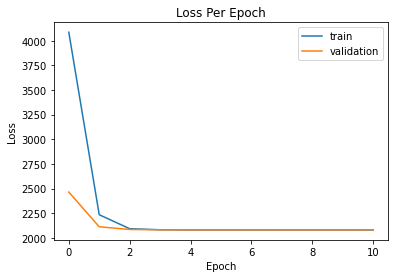

In [50]:
plt.plot(dense_model_7_history.history['loss'])
plt.plot(dense_model_7_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## This model is the same as the first one, but it uses elu instead of relu for its activations. That alone was enough to almost halve the loss. We seem to be on the right track adjusting activation functions. Slightly interesting is the loss plot, which shows a dropoff between plateaus.

Text(0, 0.5, 'Loss (MSE)')

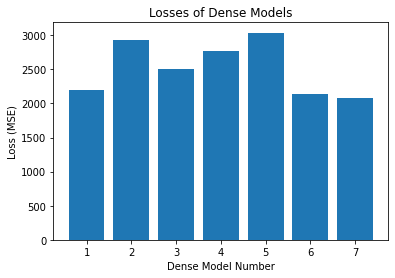

In [51]:
plt.bar(range(1,len(dense_scores)+1), dense_scores)
plt.xticks(range(1,len(dense_scores)+1))
plt.title('Losses of Dense Models')
plt.xlabel('Dense Model Number')
plt.ylabel('Loss (MSE)')

In [52]:
dense_model_8 = Sequential()
dense_model_8.add(layers.Dense(64, activation='tanh', input_shape=(input_len,)))
dense_model_8.add(layers.Dense(32, activation='tanh'))
dense_model_8.add(layers.Dense(8, activation='tanh'))
dense_model_8.add(layers.Dense(32, activation='tanh'))
dense_model_8.add(layers.Dense(64, activation='tanh'))
dense_model_8.add(layers.Dense(input_len, activation='tanh'))
dense_model_8.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_45 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_47 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_48 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_49 (Dense)             (None, 128)               8320      
Total params: 21,320
Trainable params: 21,320
Non-trainable params: 0
__________________________________________________

In [53]:
dense_model_8_history = dense_model_8.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_8.save_weights('/content/gdrive/My Drive/dense_model_8.h5')

Epoch 1/40
22/22 [==============================] - 0s 7ms/step - loss: 6820.4844 - mse: 6820.4844 - val_loss: 6763.9805 - val_mse: 6763.9805
Epoch 2/40
22/22 [==============================] - 0s 3ms/step - loss: 6729.0405 - mse: 6729.0405 - val_loss: 6708.7578 - val_mse: 6708.7578
Epoch 3/40
22/22 [==============================] - 0s 3ms/step - loss: 6703.5898 - mse: 6703.5898 - val_loss: 6702.8745 - val_mse: 6702.8745
Epoch 4/40
22/22 [==============================] - 0s 3ms/step - loss: 6700.9932 - mse: 6700.9932 - val_loss: 6701.9736 - val_mse: 6701.9736
Epoch 5/40
22/22 [==============================] - 0s 4ms/step - loss: 6700.4272 - mse: 6700.4272 - val_loss: 6701.6328 - val_mse: 6701.6328
Epoch 6/40
22/22 [==============================] - 0s 4ms/step - loss: 6700.1650 - mse: 6700.1650 - val_loss: 6701.4380 - val_mse: 6701.4380
Epoch 7/40
22/22 [==============================] - 0s 4ms/step - loss: 6700.0039 - mse: 6700.0039 - val_loss: 6701.3071 - val_mse: 6701.3071
Epoch 

In [54]:
dense_model_8_score = dense_model_8.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_8_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 6701.2002 - mse: 6701.2002


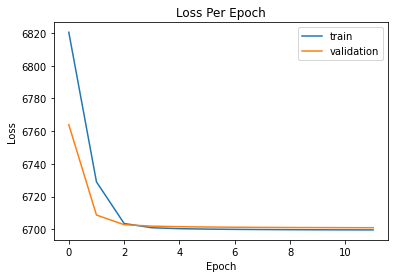

In [55]:
plt.plot(dense_model_8_history.history['loss'])
plt.plot(dense_model_8_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## I am not a fan of using tanh as an activation function, and these results further confirm my feelings on the matter. Tanh gradients are not great for backpropagation, because they are often too small. As you can see in the plot, training and validation loss stay fairly apart.

Text(0, 0.5, 'Loss (MSE)')

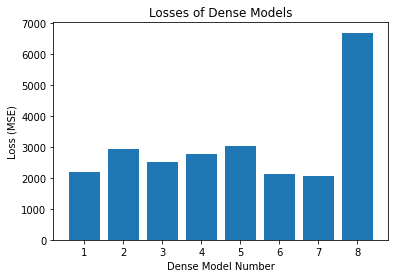

In [56]:
plt.bar(range(1,len(dense_scores)+1), dense_scores)
plt.xticks(range(1,len(dense_scores)+1))
plt.title('Losses of Dense Models')
plt.xlabel('Dense Model Number')
plt.ylabel('Loss (MSE)')

In [57]:
dense_model_9 = Sequential()
dense_model_9.add(layers.Dense(64, input_shape=(input_len,)))
dense_model_9.add(layers.LeakyReLU(alpha=0.1))
dense_model_9.add(layers.Dense(32))
dense_model_9.add(layers.LeakyReLU(alpha=0.1))
dense_model_9.add(layers.Dense(8))
dense_model_9.add(layers.LeakyReLU(alpha=0.1))
dense_model_9.add(layers.Dense(32))
dense_model_9.add(layers.LeakyReLU(alpha=0.1))
dense_model_9.add(layers.Dense(64))
dense_model_9.add(layers.LeakyReLU(alpha=0.1))
dense_model_9.add(layers.Dense(input_len))
dense_model_9.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 264       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 32)               

In [58]:
dense_model_9_history = dense_model_9.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_9.save_weights('/content/gdrive/My Drive/dense_model_9.h5')

Epoch 1/40
22/22 [==============================] - 0s 9ms/step - loss: 5407.0083 - mse: 5407.0083 - val_loss: 2388.7971 - val_mse: 2388.7971
Epoch 2/40
22/22 [==============================] - 0s 4ms/step - loss: 941.9796 - mse: 941.9796 - val_loss: 180.8876 - val_mse: 180.8876
Epoch 3/40
22/22 [==============================] - 0s 4ms/step - loss: 106.1837 - mse: 106.1837 - val_loss: 78.5053 - val_mse: 78.5053
Epoch 4/40
22/22 [==============================] - 0s 4ms/step - loss: 73.4032 - mse: 73.4032 - val_loss: 70.4266 - val_mse: 70.4266
Epoch 5/40
22/22 [==============================] - 0s 4ms/step - loss: 69.3377 - mse: 69.3377 - val_loss: 69.3726 - val_mse: 69.3726
Epoch 6/40
22/22 [==============================] - 0s 3ms/step - loss: 68.9074 - mse: 68.9074 - val_loss: 69.1623 - val_mse: 69.1623
Epoch 7/40
22/22 [==============================] - 0s 3ms/step - loss: 68.8313 - mse: 68.8313 - val_loss: 69.3663 - val_mse: 69.3663
Epoch 8/40
22/22 [==============================

In [59]:
dense_model_9_score = dense_model_9.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_9_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 68.7905 - mse: 68.7905


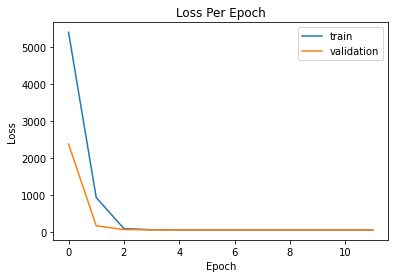

In [60]:
plt.plot(dense_model_9_history.history['loss'])
plt.plot(dense_model_9_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## The LeakyReLU results are fantastic. It's incredible how much activation functions can have an effect on a model's loss. This model has a loss value approximately one percent of the last model's loss. The only difference is their activation functions. This model looks like a winner, but we'll try dropout on it out of curiosity.

Text(0, 0.5, 'Loss (MSE)')

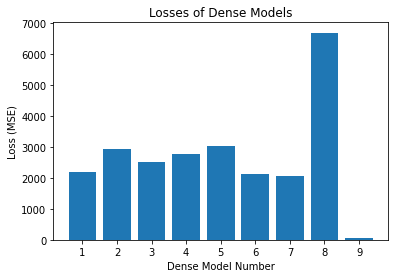

In [61]:
plt.bar(range(1,len(dense_scores)+1), dense_scores)
plt.xticks(range(1,len(dense_scores)+1))
plt.title('Losses of Dense Models')
plt.xlabel('Dense Model Number')
plt.ylabel('Loss (MSE)')

In [62]:
dense_model_10 = Sequential()
dense_model_10.add(layers.Dense(64, input_shape=(input_len,)))
dense_model_10.add(layers.Dropout(0.2))
dense_model_10.add(layers.LeakyReLU(alpha=0.1))
dense_model_10.add(layers.Dense(32))
dense_model_10.add(layers.LeakyReLU(alpha=0.1))
dense_model_10.add(layers.Dense(8))
dense_model_10.add(layers.LeakyReLU(alpha=0.1))
dense_model_10.add(layers.Dense(32))
dense_model_10.add(layers.Dropout(0.2))
dense_model_10.add(layers.LeakyReLU(alpha=0.1))
dense_model_10.add(layers.Dense(64))
dense_model_10.add(layers.Dropout(0.2))
dense_model_10.add(layers.LeakyReLU(alpha=0.1))
dense_model_10.add(layers.Dense(input_len))
dense_model_10.compile(optimizer='adam', loss='mse', metrics=['mse'])
dense_model_10.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 8)                 264       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8)                

In [63]:
dense_model_10_history = dense_model_10.fit(x=x_train, y=x_train, batch_size=64, epochs=40, verbose=1, validation_split=0.2, callbacks=[stopper])
dense_model_10.save_weights('/content/gdrive/My Drive/dense_model_10.h5')

Epoch 1/40
22/22 [==============================] - 0s 8ms/step - loss: 5050.8687 - mse: 5050.8687 - val_loss: 1781.8938 - val_mse: 1781.8938
Epoch 2/40
22/22 [==============================] - 0s 3ms/step - loss: 1514.2201 - mse: 1514.2201 - val_loss: 380.8250 - val_mse: 380.8250
Epoch 3/40
22/22 [==============================] - 0s 4ms/step - loss: 797.1252 - mse: 797.1252 - val_loss: 290.6915 - val_mse: 290.6915
Epoch 4/40
22/22 [==============================] - 0s 4ms/step - loss: 626.5257 - mse: 626.5257 - val_loss: 237.6956 - val_mse: 237.6956
Epoch 5/40
22/22 [==============================] - 0s 4ms/step - loss: 543.5822 - mse: 543.5822 - val_loss: 246.9532 - val_mse: 246.9532
Epoch 6/40
22/22 [==============================] - 0s 4ms/step - loss: 458.4242 - mse: 458.4242 - val_loss: 201.7696 - val_mse: 201.7696
Epoch 7/40
22/22 [==============================] - 0s 4ms/step - loss: 435.2568 - mse: 435.2568 - val_loss: 292.9972 - val_mse: 292.9972
Epoch 8/40
22/22 [==========

In [64]:
dense_model_10_score = dense_model_10.evaluate(x=x_test, y=x_test, verbose=1)
dense_scores.append(dense_model_10_score[0])

14/14 [==============================] - 0s 2ms/step - loss: 203.4463 - mse: 203.4463


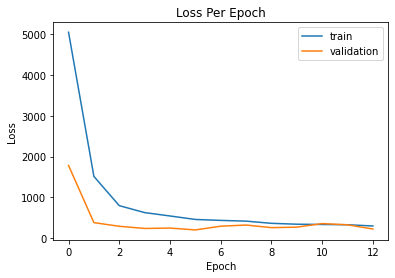

In [65]:
plt.plot(dense_model_10_history.history['loss'])
plt.plot(dense_model_10_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## The loss is still good, but the last model's was better, so we'll choose that model to detect anomalies later.

Text(0, 0.5, 'Loss (MSE)')

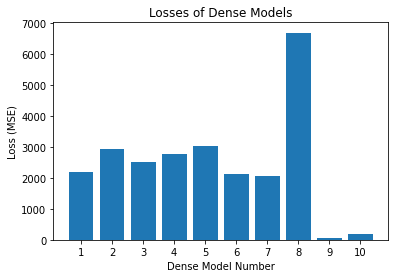

In [66]:
plt.bar(range(1,len(dense_scores)+1), dense_scores)
plt.xticks(range(1,len(dense_scores)+1))
plt.title('Losses of Dense Models')
plt.xlabel('Dense Model Number')
plt.ylabel('Loss (MSE)')

In [67]:
conv_model_1 = Sequential()
conv_model_1.add(layers.Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_len, 1)))
conv_model_1.add(layers.Conv1D(filters=32, kernel_size=7, activation='relu'))
conv_model_1.add(layers.Conv1DTranspose(filters=32, kernel_size=7, activation='relu'))
conv_model_1.add(layers.Conv1DTranspose(filters=64, kernel_size=7, activation='relu'))
conv_model_1.add(layers.Conv1DTranspose(filters=1, kernel_size=1, activation='relu'))
conv_model_1.compile(optimizer='adam', loss='mse', metrics=['mse'])
conv_model_1.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 122, 64)           512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 32)           14368     
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 122, 32)           7200      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 128, 64)           14400     
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 128, 1)            65        
Total params: 36,545
Trainable params: 36,545
Non-trainable params: 0
_________________________________________________________________


In [68]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [69]:
x_train.shape

(1707, 128, 1)

In [70]:
conv_model_1_history = conv_model_1.fit(x_train, x_train, batch_size=64, steps_per_epoch=len(x_train)/64, epochs=40, verbose=1, validation_split=0.2, callbacks=stopper)
conv_model_1.save_weights('/content/gdrive/My Drive/conv_model_1.h5')

Epoch 1/40
27/26 [==============================] - 1s 19ms/step - loss: 1272.7466 - mse: 1272.7466 - val_loss: 285.9901 - val_mse: 285.9901
Epoch 2/40
27/26 [==============================] - 0s 4ms/step - loss: 209.6389 - mse: 209.6389 - val_loss: 154.5996 - val_mse: 154.5996
Epoch 3/40
27/26 [==============================] - 0s 4ms/step - loss: 127.4387 - mse: 127.4387 - val_loss: 100.4979 - val_mse: 100.4979
Epoch 4/40
27/26 [==============================] - 0s 5ms/step - loss: 86.0981 - mse: 86.0981 - val_loss: 72.6412 - val_mse: 72.6412
Epoch 5/40
27/26 [==============================] - 0s 5ms/step - loss: 64.5058 - mse: 64.5058 - val_loss: 55.4348 - val_mse: 55.4348
Epoch 6/40
27/26 [==============================] - 0s 4ms/step - loss: 49.1165 - mse: 49.1165 - val_loss: 42.1891 - val_mse: 42.1891
Epoch 7/40
27/26 [==============================] - 0s 4ms/step - loss: 37.5231 - mse: 37.5231 - val_loss: 31.8560 - val_mse: 31.8560
Epoch 8/40
27/26 [=============================

In [71]:
conv_model_1_score = conv_model_1.evaluate(x_test, x_test, verbose=1)

14/14 [==============================] - 0s 7ms/step - loss: 6.4947 - mse: 6.4947


## After all of the trouble finding a good dense autoencoder, it is astounding how well this convolutional autoencoder works. I'm almost concerned that it works too well. We'll see later.

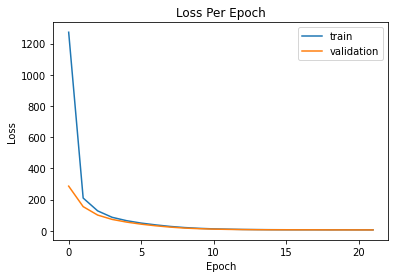

In [72]:
plt.plot(conv_model_1_history.history['loss'])
plt.plot(conv_model_1_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## I had massive issues with this, becuase multiple LSTM layers are awful for the exploding gradient problem. In my experience, success largely depended on getting lucky with initial weights.

In [73]:
lstm_model_2 = Sequential()
lstm_model_2.add(layers.LSTM(16, activation='relu', recurrent_activation='relu', input_shape=(input_len, 1)))
lstm_model_2.add(layers.RepeatVector(input_len))
lstm_model_2.add(layers.LSTM(4, activation='relu', recurrent_activation='relu', return_sequences=True))
lstm_model_2.add(layers.LSTM(16, activation='relu', recurrent_activation='relu', return_sequences=True))
lstm_model_2.add(layers.TimeDistributed(layers.Dense(1)))
lstm_model_2.compile(optimizer='SGD', loss='mse', metrics=['mse'])
lstm_model_2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 128, 16)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 4)            336       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 16)           1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 128, 1)            17        
Total params: 2,849
Trainable params: 2,849
Non-trainable params: 0
_________________________________________________________________


In [74]:
lstm_model_2_history = lstm_model_2.fit(x_train, x_train, batch_size=16, steps_per_epoch=len(x_train)/16, epochs=40, verbose=1, validation_split=0.2, callbacks=stopper)
lstm_model_2.save_weights('/content/gdrive/My Drive/lstm_model_2.h5')

Epoch 1/40
107/106 [==============================] - 58s 538ms/step - loss: 1660.0247 - mse: 1660.0247 - val_loss: 160.8193 - val_mse: 160.8193
Epoch 2/40
107/106 [==============================] - 57s 537ms/step - loss: 90.4483 - mse: 90.4483 - val_loss: 70.9920 - val_mse: 70.9920
Epoch 3/40
107/106 [==============================] - 58s 546ms/step - loss: 70.2345 - mse: 70.2345 - val_loss: 69.9346 - val_mse: 69.9346
Epoch 4/40
107/106 [==============================] - 55s 515ms/step - loss: 69.3196 - mse: 69.3196 - val_loss: 69.9087 - val_mse: 69.9087
Epoch 5/40
107/106 [==============================] - 57s 530ms/step - loss: 69.9043 - mse: 69.9043 - val_loss: 69.9100 - val_mse: 69.9100
Epoch 6/40
107/106 [==============================] - 56s 525ms/step - loss: 69.1655 - mse: 69.1655 - val_loss: 69.9097 - val_mse: 69.9097
Epoch 7/40
107/106 [==============================] - 58s 541ms/step - loss: 69.7291 - mse: 69.7291 - val_loss: 69.9087 - val_mse: 69.9087
Epoch 8/40
107/106 [=

In [76]:
lstm_model_2_score = lstm_model_2.evaluate(x_test, x_test, verbose=1)


14/14 [==============================] - 1s 37ms/step - loss: 69.2286 - mse: 69.2286


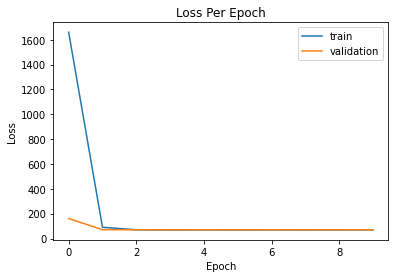

In [77]:
plt.plot(lstm_model_2_history.history['loss'])
plt.plot(lstm_model_2_history.history['val_loss'])
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

## As can be seen above, the LSTM took the longest to train, but it also took the fewest epochs to reach a good loss.

Text(0, 0.5, 'Loss (MSE)')

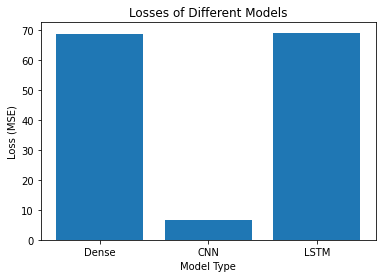

In [78]:
plt.bar(['Dense', 'CNN', 'LSTM'], [dense_model_9_score[0], conv_model_1_score[0], lstm_model_2_score[0]])
plt.title('Losses of Different Models')
plt.xlabel('Model Type')
plt.ylabel('Loss (MSE)')

## Using the models with the best loss in each category, we can see that the Dense autoencoder performed similar to the LSTM autoencoder. The CNN autoencoder did very well, even on the testing data, but I'm still worried about overfitting.

In [79]:
dense_threshold = dense_model_9_score[0]
conv_threshold = conv_model_1_score[0]
lstm_threshold = lstm_model_2_score[0]

In [80]:
df['true_anomaly'] = False
df['dense_anomaly'] = False
df['cnn_anomaly'] = False
df['lstm_anomaly'] = False
df

,value,true_anomaly,dense_anomaly,cnn_anomaly,lstm_anomaly
timestamp,,,,,
2015-08-31 18:22:00,90,False,False,False,False
2015-08-31 18:32:00,80,False,False,False,False
2015-08-31 18:57:00,84,False,False,False,False
2015-08-31 19:07:00,94,False,False,False,False
2015-08-31 19:12:00,90,False,False,False,False
...,...,...,...,...,...
2015-09-17 16:04:00,81,False,False,False,False
2015-09-17 16:09:00,89,False,False,False,False
2015-09-17 16:14:00,87,False,False,False,False


In [81]:
for anomaly in relevant_anomalies:
    df.loc[anomaly[0]:anomaly[1], 'true_anomaly']= True
    
df

,value,true_anomaly,dense_anomaly,cnn_anomaly,lstm_anomaly
timestamp,,,,,
2015-08-31 18:22:00,90,False,False,False,False
2015-08-31 18:32:00,80,False,False,False,False
2015-08-31 18:57:00,84,False,False,False,False
2015-08-31 19:07:00,94,False,False,False,False
2015-08-31 19:12:00,90,False,False,False,False
...,...,...,...,...,...
2015-09-17 16:04:00,81,True,False,False,False
2015-09-17 16:09:00,89,True,False,False,False
2015-09-17 16:14:00,87,True,False,False,False


In [82]:
data = df['value'].to_numpy()
data

array([90, 80, 84, ..., 87, 82, 83])

## For each of the following, I re-ran the associated code blocks and tweaked the thresholds to determine what the models thought were an anomalies. 

In [87]:
df['dense_anomaly'] = False

In [88]:
for i in range(len(data)-input_len+1):
    prediction = dense_model_9.predict(np.expand_dims(data[i:i+input_len], 0))
    if mean_squared_error(data[i:i+input_len], np.squeeze(prediction)) > (dense_threshold * 1.8):
        df.loc[i:(i+input_len), 'dense_anomaly'] = True
        print(i)

2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372


In [89]:
f1_score(df['true_anomaly'], df['dense_anomaly'])

0.9915611814345991

In [90]:
confusion_matrix(df['true_anomaly'], df['dense_anomaly'])

array([[2261,    0],
       [   4,  235]])

## As you can see from this f1-score and the confusion matrix, the model is almost perfect at detecting the anomaly in the dataset. The only issue is a four false positives. By the look of things though, the models was actually catching the anomaly before it was even labeled to start.

In [91]:
df['cnn_anomaly'] = False

In [92]:
for i in range(len(data)-input_len+1):
    prediction = conv_model_1.predict(np.expand_dims(data[i:i+input_len], [0,2]))
    if mean_squared_error(data[i:i+input_len], np.squeeze(prediction)) > (conv_threshold * 2.6):
        df.loc[i:(i+input_len), 'cnn_anomaly'] = True
        print(i)

22
23
24
25
36
37
38
58
1141
1142
1144
1145
1262
1263
1264
2063
2078
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2280
2281
2282
2283
2284
2285
2286
2287
2295
2296
2303
2304
2305
2306
2307
2308
2309
2310
2312
2333
2334
2335
2336


In [93]:
f1_score(df['true_anomaly'], df['cnn_anomaly'])

0.4051896207584831

In [94]:
confusion_matrix(df['true_anomaly'], df['cnn_anomaly'])

array([[1701,  560],
       [  36,  203]])

## Unfortunately, this f1-score and confusion matrix confrim what I suspected about the convolutional autoencoder, that it was over fit to the model. I wanted to see what it would be like, but I could have avoided the overfitting by adding dropout. There wasn't much that could be done to improve the f1-score, because there were as many false negative as false positives. This means that a higher threshold will be unlikely to help.

In [95]:
df['lstm_anomaly'] = False

In [96]:
for i in range(len(data)-input_len+1):
    prediction = lstm_model_2.predict(np.expand_dims(data[i:i+input_len], [0,2]))
    if mean_squared_error(data[i:i+input_len], np.squeeze(prediction)) > (lstm_threshold * 1.7):
        df.loc[i:(i+input_len), 'lstm_anomaly'] = True
        print(i)

2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372


In [97]:
f1_score(df['true_anomaly'], df['lstm_anomaly'])

0.9979035639412999

In [98]:
confusion_matrix(df['true_anomaly'], df['lstm_anomaly'])

array([[2261,    0],
       [   1,  238]])

## Interestingly enough, the results from this anomaly detection are almost perfect. Not only that, like the Dense autoencoder, the only mistake this autoencoder made was detecting the anomaly before it was officially there.